In [1]:
import itertools
import json
from pathlib import Path
import re

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

%matplotlib inline
sns.set_style("whitegrid")
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
#set_matplotlib_formats('svg')

%load_ext autoreload
%autoreload 2
import util

In [2]:
# Path to BERT directory, containing model checkpoints
bert_path = Path("~/om2/others/bert").expanduser()
# Base model used as init checkpoint for finetuning
bert_base_model = "uncased_L-12_H-768_A-12"
# Fine-tuning tasks / models
#bert_models = [None, "QQP", "MNLI", "SST", "CoLA", "MRPC", "SNLI", "RTE"]
#bert_models = [None, "SQuAD", "QQP", "MNLI", "SST"]
bert_models = [None, "SQuAD", "QQP", "MNLI", "SST"]
checkpoint_steps = list(range(5,255,5))#list(range(50, 5050, 50))#[1000, 2000, 3000, 4000, 5000]
# Describes the particular fine-tuning regime used
finetune_desc = "finetune-250"
target_runs = [None, "run1", "run2", "run3", "run4"]

In [3]:
# For each model, load
# 1. brain decoding results
# 2. checkpoint data: global step, gradient norm information
model_metadata = {}
for model in bert_models:
    print(model)
    
    m_target_runs = [None] if model is None else target_runs
    for target_run in m_target_runs:
        target_run_str = "" if target_run is None else "-%s" % target_run
        
        if model is None:
            model_dir = bert_path / bert_base_model
        else:
            # DEV
            model_dir = bert_path / ("%s.%s.%s%s" % (finetune_desc, bert_base_model, model, target_run_str))

        try:
            model_metadata[model, target_run] = util.load_bert_finetune_metadata(model_dir, checkpoint_steps)
        except: pass
            
        print("\t", target_run)

        # brain decoding results for each checkpoint step
        for checkpoint_step in checkpoint_steps:
            decoding_perf_path = "perf.384sentences.bert.base%s.csv" % \
                ("" if model is None else ".%s-%s-%d%s" % (finetune_desc, model, checkpoint_step, target_run_str))
            try:
                decoding_perf = pd.read_csv(decoding_perf_path, index_col=[0, 1])
            except: continue

            for subj, subj_row in decoding_perf.loc["ridge"].iterrows():
                model_metadata[model, target_run]["steps"][checkpoint_step]["decoding_mean_%s" % subj] = subj_row.mean()
                model_metadata[model, target_run]["steps"][checkpoint_step]["decoding_std_%s" % subj] = subj_row.std()

            model_metadata[model, target_run]["steps"][checkpoint_step].update({
                "decoding_mean": decoding_perf.loc["ridge"].mean().mean(),
                "decoding_std": decoding_perf.loc["ridge"].mean(axis=1).std()
            })

None


/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Missing training events file in savedir: %s /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
Missing eval events data in savedir: /home/jgauthie/om2/others/bert/uncased_L-12_H-768_A-12
	 None
SQuAD
	 None
	 run1
	 run2
	 run3
	 run4
QQP
	 None
	 run1
	 run2
	 run3
	 run4
MNLI
	 None
	 run1
	 run2
	 run3
	 run4
SST
	 None
	 run1
	 run2
	 run3
	 run4


In [4]:
# SQuAD results need to be loaded separately from manual eval.
if "SQuAD" in bert_models:
    for target_run in target_runs:
        target_run_str = "" if target_run is None else "-%s" % target_run
        model_dir = bert_path / ("%s.%s.SQuAD%s" % (finetune_desc, bert_base_model, target_run_str))

        for checkpoint_step in checkpoint_steps:
            pred_dir = model_dir / "predictions" / str(checkpoint_step)
            try:
                with (pred_dir / "results.json").open() as results_f:
                    results = json.load(results_f)
                model_metadata["SQuAD"]["steps"][checkpoint_step]["eval_accuracy"] = results["best_f1"] / 100.
            except: pass

In [5]:
all_subjects = decoding_perf.index.get_level_values(1).unique()
all_subjects

Index(['P01', 'M02', 'M04', 'M07', 'M08', 'M09', 'M14', 'M15'], dtype='object', name='subject')

In [6]:
# Flatten model results into a single collection.
model_metadata_flat = []

for (model, target_run), metadata in model_metadata.items():
    for step, step_data in metadata["steps"].items():
        for subject in all_subjects:
            model_metadata_flat.append((model if model is not None else "LM",
                                        target_run if target_run is not None else "NA", subject, step,
                                        step_data.get("decoding_mean_%s" % subject, np.nan), step_data.get("decoding_std_%s" % subject, np.nan),
                                        metadata.get("first_train_loss", None), metadata.get("first_train_loss_norm", None),
                                        step_data.get("train_loss", None), step_data.get("train_loss_norm", None),
                                        step_data.get("total_global_norms", None),
                                        step_data.get("eval_loss"), step_data.get("eval_accuracy")))
        
df = pd.DataFrame(model_metadata_flat, columns=("model", "run", "subject", "step", "decoding_mean", "decoding_std",
                                                "first_train_loss", "first_train_loss_norm", "train_loss", "train_loss_norm",
                                                "total_global_norms",
                                                "eval_loss", "eval_accuracy")).sort_values(["model", "subject", "step"])

In [7]:
df.tail()

model   run subject  step  decoding_mean  decoding_std  first_train_loss  \
6784   SST  run4     P01   245      79.629630     21.775343          0.783930   
5592   SST  run1     P01   250      78.171958     19.331106          0.717911   
5992   SST  run2     P01   250      69.788360     16.141863          0.775721   
6392   SST  run3     P01   250      77.523810     21.622916          0.716799   
6792   SST  run4     P01   250      79.732804     21.812020          0.783930   

      first_train_loss_norm  train_loss  train_loss_norm  total_global_norms  \
6784               0.391965    0.118796         0.059398          300.205739   
5592               0.358956    0.127800         0.063900           11.920548   
5992               0.387860    0.217266         0.108633          350.472056   
6392               0.358399    0.154268         0.077134          365.019650   
6792               0.391965    0.312814         0.156407          304.774125   

      eval_loss  eval_accuracy  
6784   0.245080       0.902500  
5592   0.226637       0.917431  
5992   0.242401       0.905963  
6392   0.248986       0.904817  
6792   0.252737       0.900229

In [9]:
df["train_loss_delta"] = df["train_loss"] - df["first_train_loss"]
df["train_loss_norm_delta"] = df["train_loss_norm"] - df["first_train_loss_norm"]

df["eval_accuracy_norm"] = df.groupby(["model", "run"]).eval_accuracy.fillna(0.0).transform(lambda accs: (accs - accs.min()) / (accs.max() - accs.min()))

df["decoding_mean_delta"] = df.groupby(["model", "run", "subject"]).decoding_mean.transform(lambda xs: xs - xs.iloc[0])
df.head()

model run subject  step  decoding_mean  decoding_std  first_train_loss  \
1     LM  NA     M02     5      61.005291     14.564277               NaN   
9     LM  NA     M02    10      61.005291     14.564277               NaN   
17    LM  NA     M02    15      61.005291     14.564277               NaN   
25    LM  NA     M02    20      61.005291     14.564277               NaN   
33    LM  NA     M02    25      61.005291     14.564277               NaN   

    first_train_loss_norm  train_loss  train_loss_norm  total_global_norms  \
1                     NaN         NaN              NaN                 NaN   
9                     NaN         NaN              NaN                 NaN   
17                    NaN         NaN              NaN                 NaN   
25                    NaN         NaN              NaN                 NaN   
33                    NaN         NaN              NaN                 NaN   

    eval_loss  eval_accuracy  decoding_mean_rolling  train_loss_delta  \
1         NaN            NaN                    NaN               NaN   
9         NaN            NaN                    NaN               NaN   
17        NaN            NaN                    NaN               NaN   
25        NaN            NaN                    NaN               NaN   
33        NaN            NaN              61.005291               NaN   

    train_loss_norm_delta  eval_accuracy_norm  decoding_mean_delta  
1                     NaN                 0.0                  0.0  
9                     NaN                 0.0                  0.0  
17                    NaN                 0.0                  0.0  
25                    NaN                 0.0                  0.0  
33                    NaN                 0.0                  0.0

In [10]:
ROLLING_WINDOW_SIZE = 5
grouped = df.groupby(["model", "run", "subject"])
for col in ["decoding_mean", "decoding_mean_delta", "eval_accuracy", "train_loss"]:
    df["%s_rolling" % col] = grouped[col].transform(lambda rows: rows.rolling(ROLLING_WINDOW_SIZE).mean())

In [11]:
df.tail()

model   run subject  step  decoding_mean  decoding_std  first_train_loss  \
6784   SST  run4     P01   245      79.629630     21.775343          0.783930   
5592   SST  run1     P01   250      78.171958     19.331106          0.717911   
5992   SST  run2     P01   250      69.788360     16.141863          0.775721   
6392   SST  run3     P01   250      77.523810     21.622916          0.716799   
6792   SST  run4     P01   250      79.732804     21.812020          0.783930   

      first_train_loss_norm  train_loss  train_loss_norm         ...          \
6784               0.391965    0.118796         0.059398         ...           
5592               0.358956    0.127800         0.063900         ...           
5992               0.387860    0.217266         0.108633         ...           
6392               0.358399    0.154268         0.077134         ...           
6792               0.391965    0.312814         0.156407         ...           

      eval_loss  eval_accuracy  decoding_mean_rolling  train_loss_delta  \
6784   0.245080       0.902500              79.442328         -0.665133   
5592   0.226637       0.917431              77.915344         -0.590111   
5992   0.242401       0.905963              69.253439         -0.558455   
6392   0.248986       0.904817              77.474603         -0.562531   
6792   0.252737       0.900229              79.543386         -0.471115   

      train_loss_norm_delta  eval_accuracy_norm  decoding_mean_delta  \
6784              -0.332567            0.979647            31.171958   
5592              -0.295056            0.995855            29.735450   
5992              -0.279227            0.983407            21.206349   
6392              -0.281265            0.982162            28.793651   
6792              -0.235558            0.977182            31.275132   

      decoding_mean_delta_rolling  eval_accuracy_rolling  train_loss_rolling  
6784                    30.984656               0.903500            0.253227  
5592                    29.478836               0.918736            0.127800  
5992                    20.671429               0.909193            0.230665  
6392                    28.744444               0.902213            0.227378  
6792                    31.085714               0.903546            0.266295  

[5 rows x 21 columns]

## Model training analysis

Let's verify that each model is not overfitting; if it is overfitting, restrict our analysis to just the region before overfitting begins.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


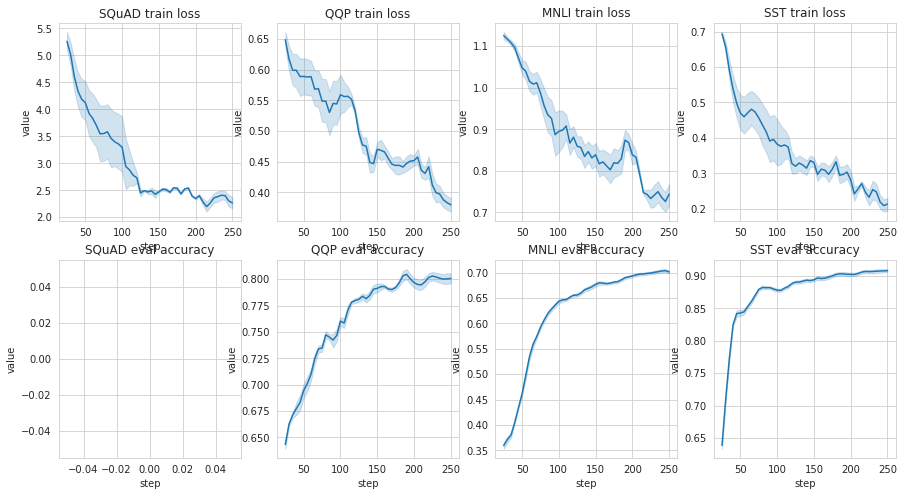

In [12]:
models = [m for m in bert_models if m is not None]
f, axs = plt.subplots(2, len(models), figsize=(15, 8))

for model, ax in zip(models, axs[0]):
    model_data = pd.melt(df[df.model == model], id_vars=["run", "step"], value_vars=["train_loss_rolling"])
    sns.lineplot(data=model_data, x="step", y="value", ax=ax)
    ax.set_title("%s train loss" % model)
    
for model, ax in zip(models, axs[1]):
    model_data = pd.melt(df[df.model == model], id_vars=["run", "step"], value_vars=["eval_accuracy_rolling"])
    sns.lineplot(data=model_data, x="step", y="value", ax=ax)
    ax.set_title("%s eval accuracy" % model)

MRPC and RTE are definitely overfitting — let's exclude some of the later training steps.

In [13]:
df = df.drop(index=df[(df.model == "MRPC") & (df.step > 750)].index)
df = df.drop(index=df[(df.model == "RTE") & (df.step > 1000)].index)
df.describe()

step  decoding_mean  decoding_std  first_train_loss  \
count  6800.000000    6400.000000   6400.000000       6400.000000   
mean    127.500000     111.201761     24.383333          2.145495   
std      72.159655      30.700564      6.578447          2.225108   
min       5.000000      44.455026     10.494769          0.671535   
25%      65.000000      86.839286     19.947352          0.717633   
50%     127.500000     115.268519     23.479487          0.924551   
75%     190.000000     136.547619     29.201845          2.436886   
max     250.000000     167.957672     40.202390          6.029931   

       first_train_loss_norm   train_loss  train_loss_norm  \
count            4800.000000  6400.000000      4800.000000   
mean                0.369049     1.205827         0.243605   
std                 0.022074     1.279646         0.085677   
min                 0.335767     0.095185         0.047592   
25%                 0.354351     0.416424         0.188633   
50%                 0.363414     0.704467         0.238764   
75%                 0.381016     1.287506         0.319402   
max                 0.420527     6.029931         0.420527   

       total_global_norms    eval_loss  eval_accuracy  decoding_mean_rolling  \
count         6400.000000  4800.000000    4800.000000            5888.000000   
mean           153.718030     0.536084       0.746816             111.723159   
std            172.115522     0.244846       0.135915              30.318626   
min              2.407880     0.222312       0.282500              44.749735   
25%             16.404192     0.319538       0.675220              88.886905   
50%            106.332310     0.448512       0.775000             115.585714   
75%            227.925342     0.733549       0.871562             136.729497   
max            807.520106     1.191974       0.921250             165.738624   

       train_loss_delta  train_loss_norm_delta  eval_accuracy_norm  \
count       6400.000000            4800.000000         6800.000000   
mean          -0.939668              -0.125444            0.572227   
std            1.325897               0.088890            0.389639   
min           -4.597517              -0.344372            0.000000   
25%           -0.590111              -0.183546            0.000000   
50%           -0.333560              -0.121760            0.744233   
75%           -0.169828              -0.056609            0.873813   
max            0.075408               0.037704            1.000000   

       decoding_mean_delta  decoding_mean_delta_rolling  \
count          6400.000000                  5888.000000   
mean             14.957300                    15.478698   
std              14.249500                    13.811097   
min              -6.489418                    -5.875661   
25%               0.675926                     2.234127   
50%              12.796296                    13.707937   
75%              28.083995                    28.280159   
max              63.391534                    56.979894   

       eval_accuracy_rolling  train_loss_rolling  
count            4416.000000         5888.000000  
mean                0.754911            1.182488  
std                 0.124245            1.204143  
min                 0.333500            0.127800  
25%                 0.681437            0.420003  
50%                 0.778375            0.717911  
75%                 0.875000            1.374088  
max                 0.919500            6.029931

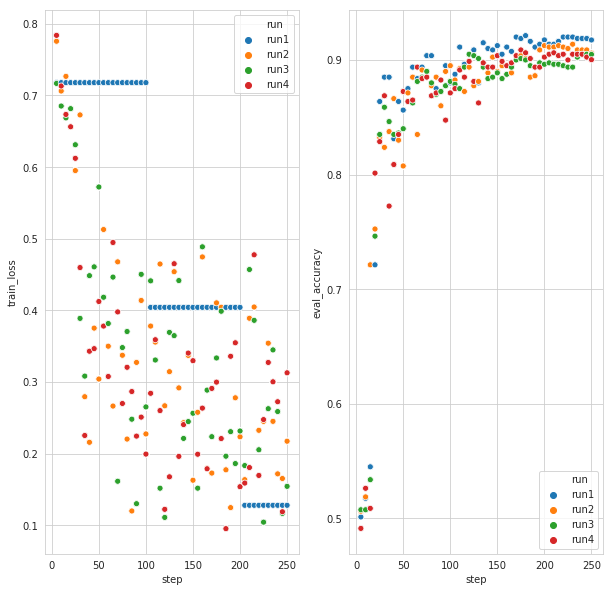

In [14]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.scatterplot(data=df[df.model == "SST"], x="step", y="train_loss", hue="run", ax=axs[0])
sns.scatterplot(data=df[df.model == "SST"], x="step", y="eval_accuracy", hue="run", ax=axs[1])

SST also converges early (around 4000 iters). We'll drop the remaining iterations.

In [15]:
df = df.drop(index=df[(df.model == "SST") & (df.step > 4000)].index)
df.describe()

step  decoding_mean  decoding_std  first_train_loss  \
count  6800.000000    6400.000000   6400.000000       6400.000000   
mean    127.500000     111.201761     24.383333          2.145495   
std      72.159655      30.700564      6.578447          2.225108   
min       5.000000      44.455026     10.494769          0.671535   
25%      65.000000      86.839286     19.947352          0.717633   
50%     127.500000     115.268519     23.479487          0.924551   
75%     190.000000     136.547619     29.201845          2.436886   
max     250.000000     167.957672     40.202390          6.029931   

       first_train_loss_norm   train_loss  train_loss_norm  \
count            4800.000000  6400.000000      4800.000000   
mean                0.369049     1.205827         0.243605   
std                 0.022074     1.279646         0.085677   
min                 0.335767     0.095185         0.047592   
25%                 0.354351     0.416424         0.188633   
50%                 0.363414     0.704467         0.238764   
75%                 0.381016     1.287506         0.319402   
max                 0.420527     6.029931         0.420527   

       total_global_norms    eval_loss  eval_accuracy  decoding_mean_rolling  \
count         6400.000000  4800.000000    4800.000000            5888.000000   
mean           153.718030     0.536084       0.746816             111.723159   
std            172.115522     0.244846       0.135915              30.318626   
min              2.407880     0.222312       0.282500              44.749735   
25%             16.404192     0.319538       0.675220              88.886905   
50%            106.332310     0.448512       0.775000             115.585714   
75%            227.925342     0.733549       0.871562             136.729497   
max            807.520106     1.191974       0.921250             165.738624   

       train_loss_delta  train_loss_norm_delta  eval_accuracy_norm  \
count       6400.000000            4800.000000         6800.000000   
mean          -0.939668              -0.125444            0.572227   
std            1.325897               0.088890            0.389639   
min           -4.597517              -0.344372            0.000000   
25%           -0.590111              -0.183546            0.000000   
50%           -0.333560              -0.121760            0.744233   
75%           -0.169828              -0.056609            0.873813   
max            0.075408               0.037704            1.000000   

       decoding_mean_delta  decoding_mean_delta_rolling  \
count          6400.000000                  5888.000000   
mean             14.957300                    15.478698   
std              14.249500                    13.811097   
min              -6.489418                    -5.875661   
25%               0.675926                     2.234127   
50%              12.796296                    13.707937   
75%              28.083995                    28.280159   
max              63.391534                    56.979894   

       eval_accuracy_rolling  train_loss_rolling  
count            4416.000000         5888.000000  
mean                0.754911            1.182488  
std                 0.124245            1.204143  
min                 0.333500            0.127800  
25%                 0.681437            0.420003  
50%                 0.778375            0.717911  
75%                 0.875000            1.374088  
max                 0.919500            6.029931

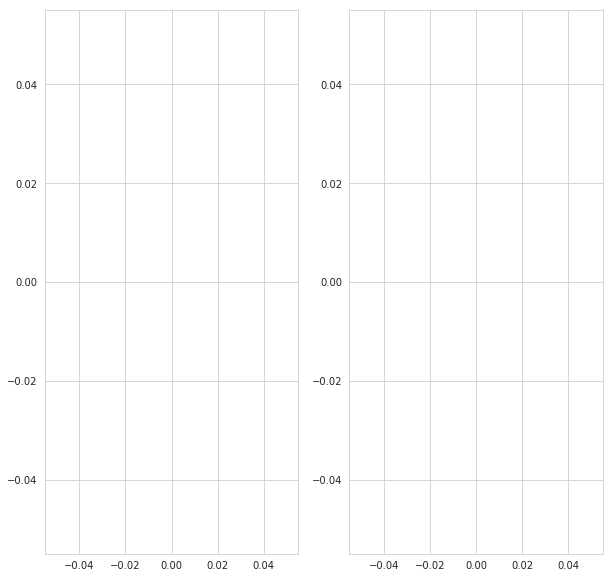

In [16]:
f, axs = plt.subplots(1, 2, figsize=(10, 10))
sns.scatterplot(data=df[df.model == "CoLA"], x="step", y="train_loss", ax=axs[0])
sns.scatterplot(data=df[df.model == "CoLA"], x="step", y="eval_accuracy", ax=axs[1])

CoLA is also overfitting — we reach near-zero training loss by around iter 2000. Drop.

In [17]:
df = df.drop(index=df[(df.model == "CoLA") & (df.step > 2000)].index)
df.describe()

step  decoding_mean  decoding_std  first_train_loss  \
count  6800.000000    6400.000000   6400.000000       6400.000000   
mean    127.500000     111.201761     24.383333          2.145495   
std      72.159655      30.700564      6.578447          2.225108   
min       5.000000      44.455026     10.494769          0.671535   
25%      65.000000      86.839286     19.947352          0.717633   
50%     127.500000     115.268519     23.479487          0.924551   
75%     190.000000     136.547619     29.201845          2.436886   
max     250.000000     167.957672     40.202390          6.029931   

       first_train_loss_norm   train_loss  train_loss_norm  \
count            4800.000000  6400.000000      4800.000000   
mean                0.369049     1.205827         0.243605   
std                 0.022074     1.279646         0.085677   
min                 0.335767     0.095185         0.047592   
25%                 0.354351     0.416424         0.188633   
50%                 0.363414     0.704467         0.238764   
75%                 0.381016     1.287506         0.319402   
max                 0.420527     6.029931         0.420527   

       total_global_norms    eval_loss  eval_accuracy  decoding_mean_rolling  \
count         6400.000000  4800.000000    4800.000000            5888.000000   
mean           153.718030     0.536084       0.746816             111.723159   
std            172.115522     0.244846       0.135915              30.318626   
min              2.407880     0.222312       0.282500              44.749735   
25%             16.404192     0.319538       0.675220              88.886905   
50%            106.332310     0.448512       0.775000             115.585714   
75%            227.925342     0.733549       0.871562             136.729497   
max            807.520106     1.191974       0.921250             165.738624   

       train_loss_delta  train_loss_norm_delta  eval_accuracy_norm  \
count       6400.000000            4800.000000         6800.000000   
mean          -0.939668              -0.125444            0.572227   
std            1.325897               0.088890            0.389639   
min           -4.597517              -0.344372            0.000000   
25%           -0.590111              -0.183546            0.000000   
50%           -0.333560              -0.121760            0.744233   
75%           -0.169828              -0.056609            0.873813   
max            0.075408               0.037704            1.000000   

       decoding_mean_delta  decoding_mean_delta_rolling  \
count          6400.000000                  5888.000000   
mean             14.957300                    15.478698   
std              14.249500                    13.811097   
min              -6.489418                    -5.875661   
25%               0.675926                     2.234127   
50%              12.796296                    13.707937   
75%              28.083995                    28.280159   
max              63.391534                    56.979894   

       eval_accuracy_rolling  train_loss_rolling  
count            4416.000000         5888.000000  
mean                0.754911            1.182488  
std                 0.124245            1.204143  
min                 0.333500            0.127800  
25%                 0.681437            0.420003  
50%                 0.778375            0.717911  
75%                 0.875000            1.374088  
max                 0.919500            6.029931

In [18]:
df = df.drop(index=df[(df.model == "QQP") & (df.step > 4000)].index)
df.describe()

step  decoding_mean  decoding_std  first_train_loss  \
count  6800.000000    6400.000000   6400.000000       6400.000000   
mean    127.500000     111.201761     24.383333          2.145495   
std      72.159655      30.700564      6.578447          2.225108   
min       5.000000      44.455026     10.494769          0.671535   
25%      65.000000      86.839286     19.947352          0.717633   
50%     127.500000     115.268519     23.479487          0.924551   
75%     190.000000     136.547619     29.201845          2.436886   
max     250.000000     167.957672     40.202390          6.029931   

       first_train_loss_norm   train_loss  train_loss_norm  \
count            4800.000000  6400.000000      4800.000000   
mean                0.369049     1.205827         0.243605   
std                 0.022074     1.279646         0.085677   
min                 0.335767     0.095185         0.047592   
25%                 0.354351     0.416424         0.188633   
50%                 0.363414     0.704467         0.238764   
75%                 0.381016     1.287506         0.319402   
max                 0.420527     6.029931         0.420527   

       total_global_norms    eval_loss  eval_accuracy  decoding_mean_rolling  \
count         6400.000000  4800.000000    4800.000000            5888.000000   
mean           153.718030     0.536084       0.746816             111.723159   
std            172.115522     0.244846       0.135915              30.318626   
min              2.407880     0.222312       0.282500              44.749735   
25%             16.404192     0.319538       0.675220              88.886905   
50%            106.332310     0.448512       0.775000             115.585714   
75%            227.925342     0.733549       0.871562             136.729497   
max            807.520106     1.191974       0.921250             165.738624   

       train_loss_delta  train_loss_norm_delta  eval_accuracy_norm  \
count       6400.000000            4800.000000         6800.000000   
mean          -0.939668              -0.125444            0.572227   
std            1.325897               0.088890            0.389639   
min           -4.597517              -0.344372            0.000000   
25%           -0.590111              -0.183546            0.000000   
50%           -0.333560              -0.121760            0.744233   
75%           -0.169828              -0.056609            0.873813   
max            0.075408               0.037704            1.000000   

       decoding_mean_delta  decoding_mean_delta_rolling  \
count          6400.000000                  5888.000000   
mean             14.957300                    15.478698   
std              14.249500                    13.811097   
min              -6.489418                    -5.875661   
25%               0.675926                     2.234127   
50%              12.796296                    13.707937   
75%              28.083995                    28.280159   
max              63.391534                    56.979894   

       eval_accuracy_rolling  train_loss_rolling  
count            4416.000000         5888.000000  
mean                0.754911            1.182488  
std                 0.124245            1.204143  
min                 0.333500            0.127800  
25%                 0.681437            0.420003  
50%                 0.778375            0.717911  
75%                 0.875000            1.374088  
max                 0.919500            6.029931

## Decoding analyses

In [19]:
MAR_DELTA_LABEL = "$\Delta$(MAR$_j$)"

### Step analysis

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


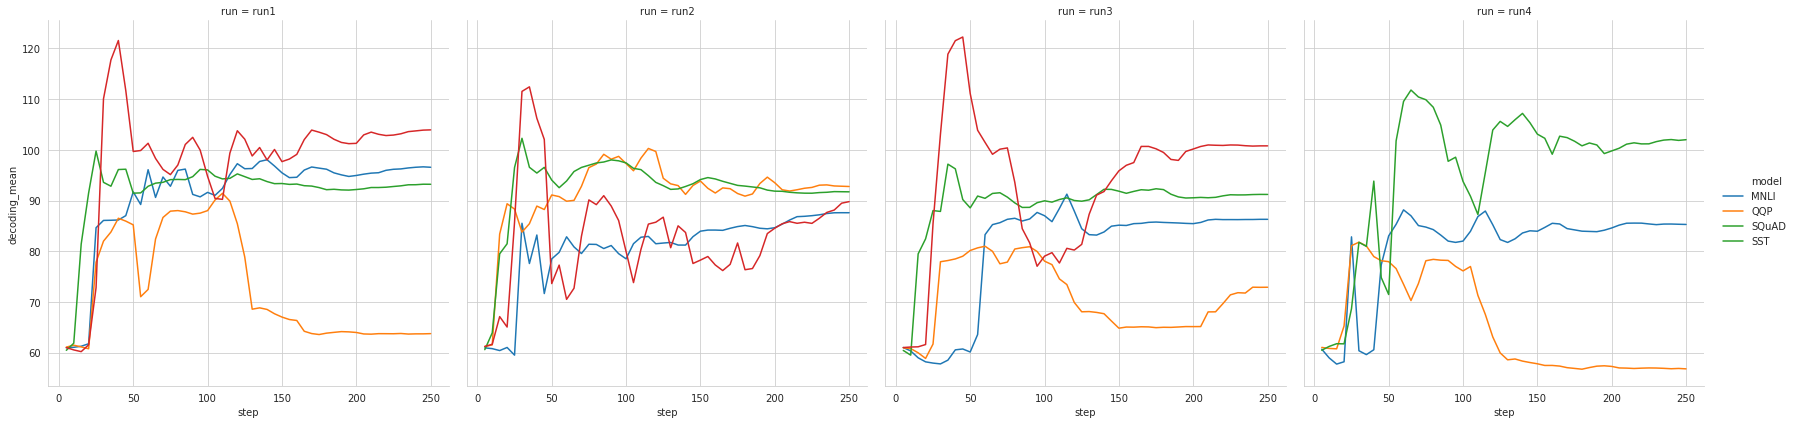

In [23]:
g = sns.FacetGrid(df[(df.subject == "M02") & ~(df.run == "NA")], col="run", size=6)
g.map(sns.lineplot, "step", "decoding_mean", "model").add_legend()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(1359.78,0.5,'$\\Delta$(MAR$_j$)')

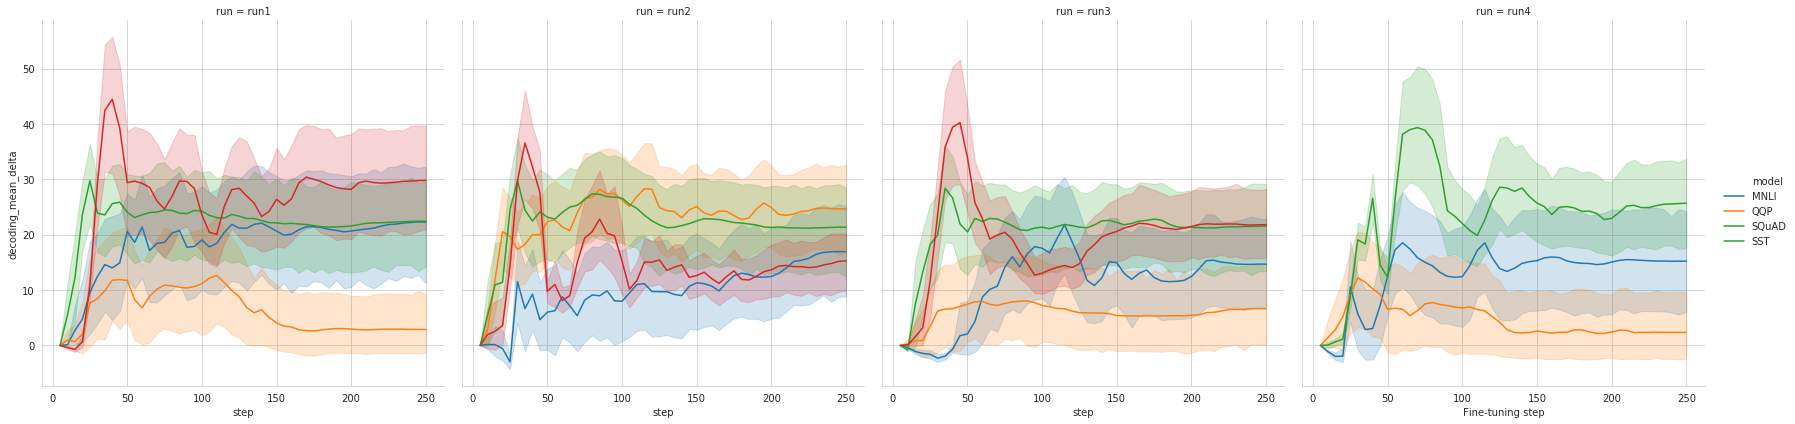

In [24]:
g = sns.FacetGrid(df[df.run != "NA"], col="run", size=6)
g.map(sns.lineplot, "step", "decoding_mean_delta", "model").add_legend()

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

Text(0,0.5,'$\\Delta$(MAR$_j$)')

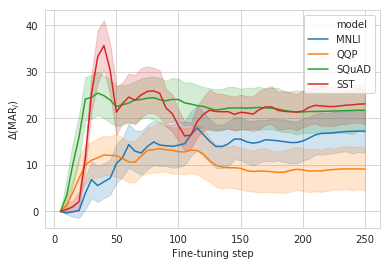

In [25]:
sns.lineplot(data=df[df.run != "NA"], x="step", y="decoding_mean_delta", hue="model")

plt.xlabel("Fine-tuning step")
plt.ylabel(MAR_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


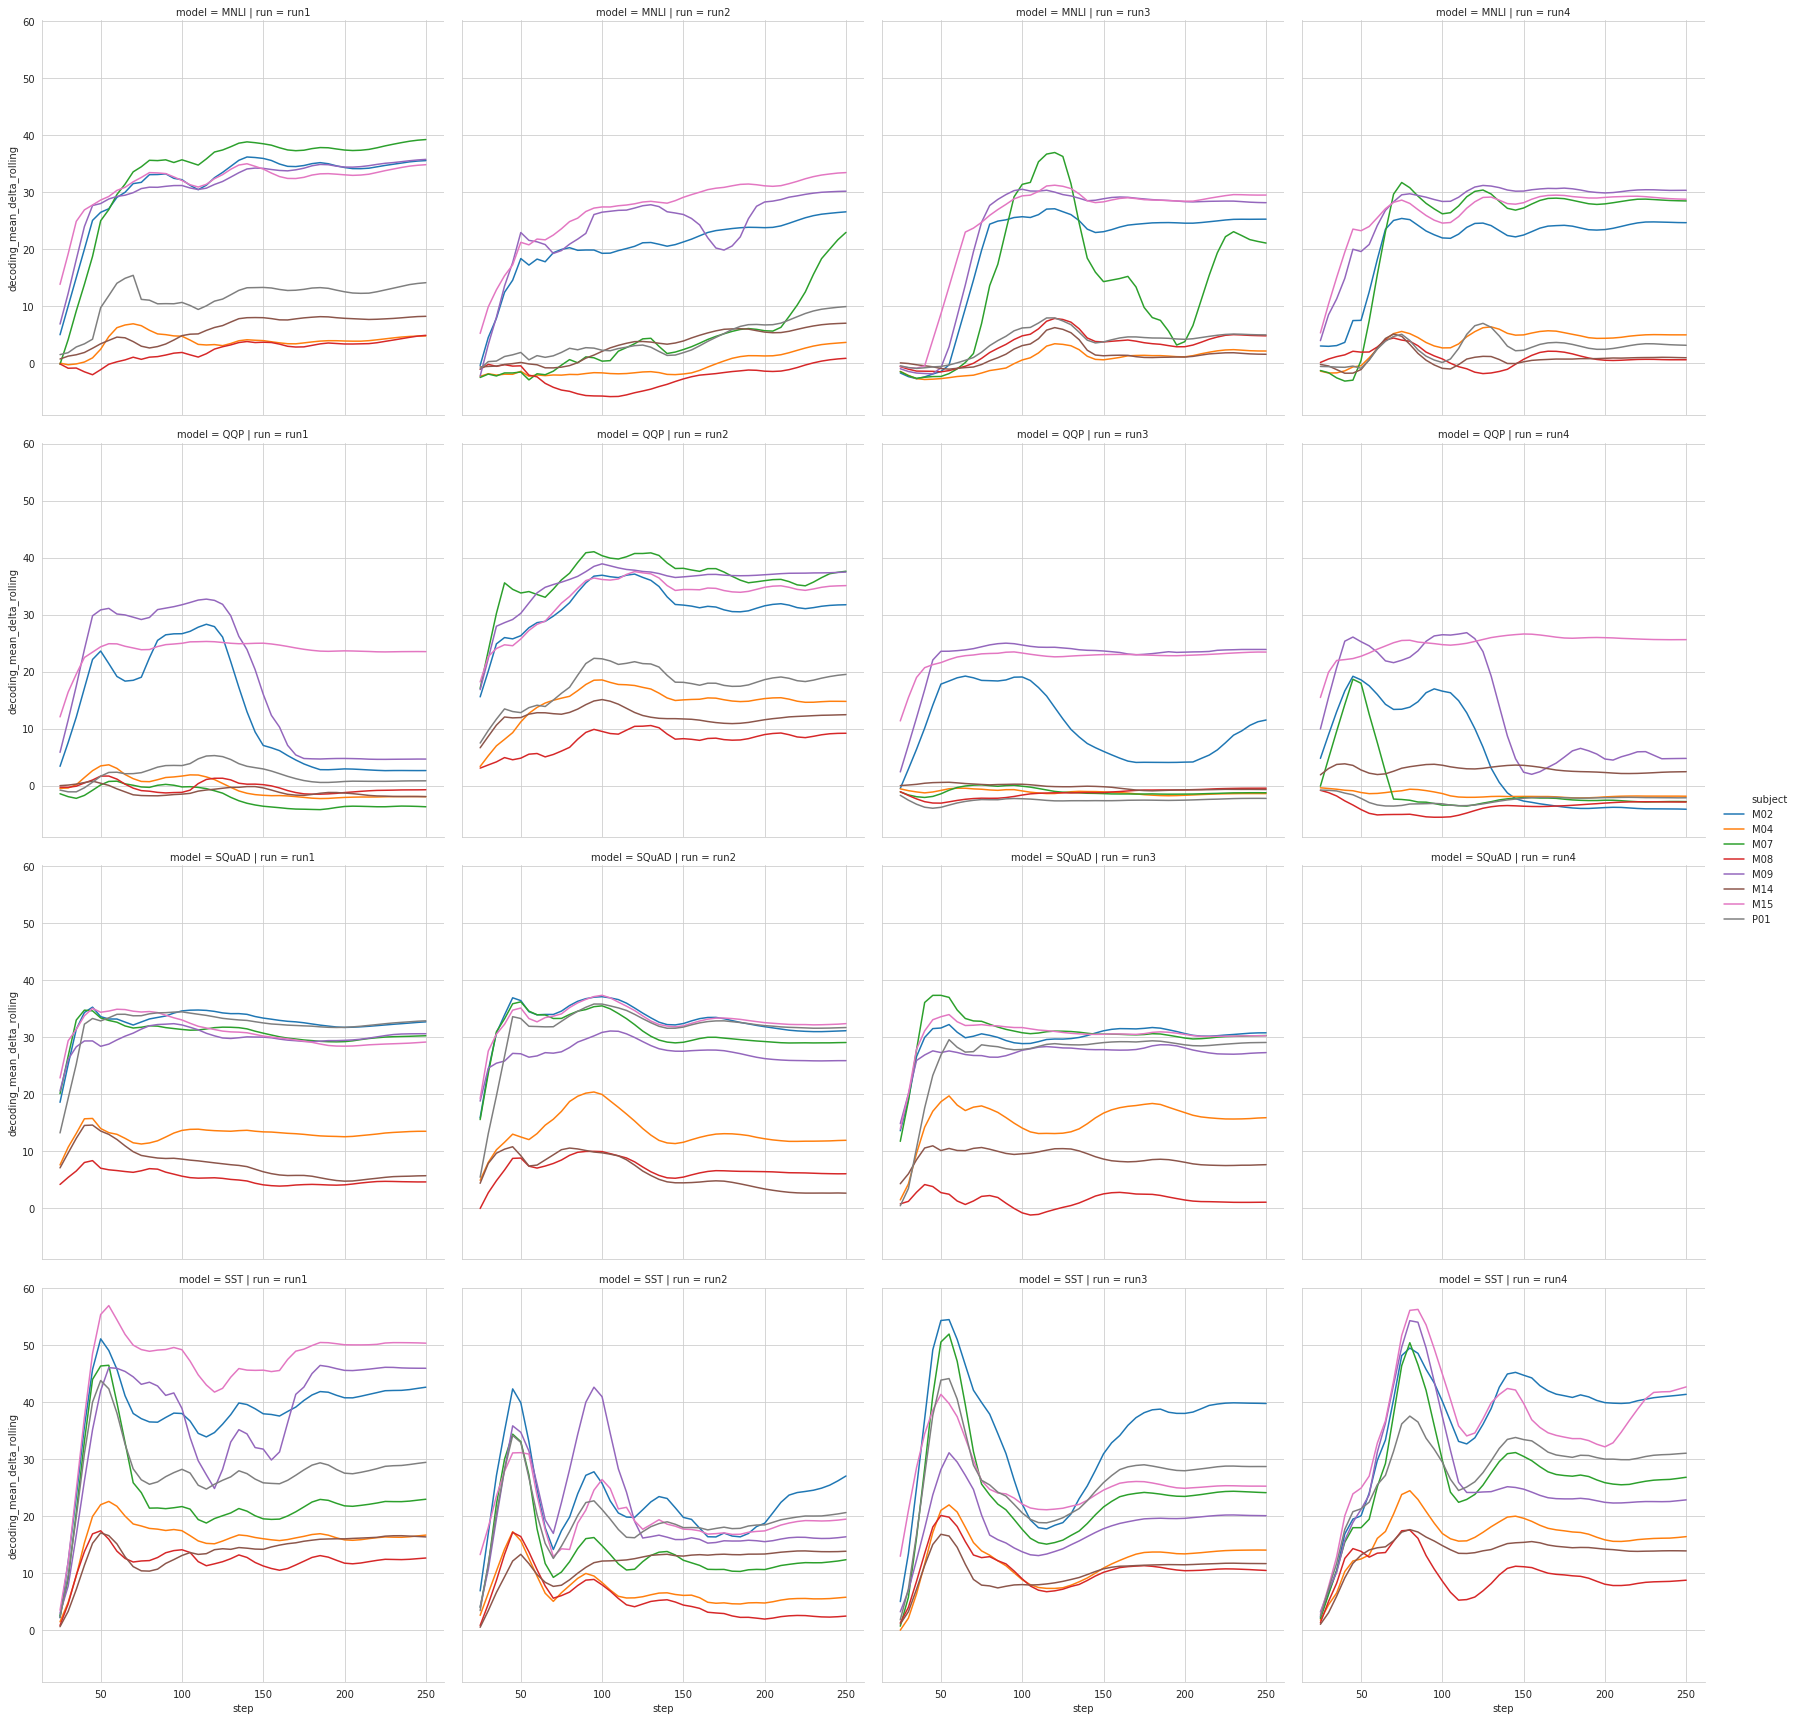

In [26]:
g = sns.FacetGrid(df[(df.model != "LM") & (df.run != "NA")], row="model", col="run", size=6)
g.map(sns.lineplot, "step", "decoding_mean_delta_rolling", "subject").add_legend()

### Gradient norm analysis

Text(0,0.5,'$\\Delta$(MAR$_j$)')

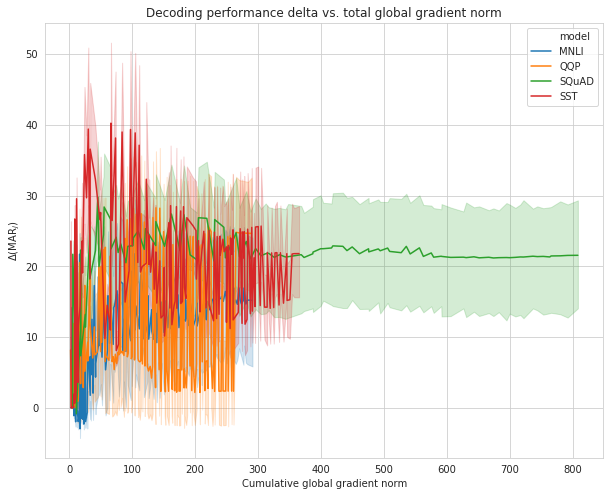

In [27]:
f, ax = plt.subplots(figsize=(10, 8))
sns.lineplot(data=df[(df.model != "LM") & (df.run != "NA")], y="decoding_mean_delta", x="total_global_norms", hue="model", ax=ax)
ax.set_title("Decoding performance delta vs. total global gradient norm")
ax.set_xlabel("Cumulative global gradient norm")
ax.set_ylabel(MAR_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/regression.py:279: RuntimeWarning: invalid value encountered in log
  grid = np.c_[np.ones(len(grid)), np.log(grid)]


Text(23.5124,0.5,'$\\Delta$(MAR$_j$)')

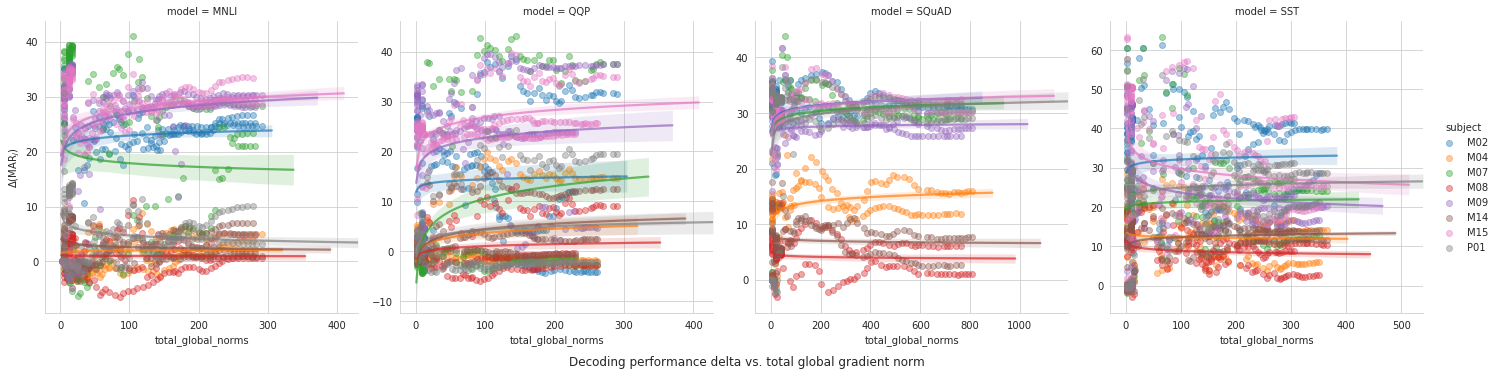

In [28]:
g = sns.lmplot(data=df[(df.model != "LM") & (df.run != "NA")], y="decoding_mean_delta", x="total_global_norms", col="model", hue="subject",
               logx=True, sharex=False, sharey=False, scatter_kws={"alpha": 0.4}, line_kws={"alpha": 0.7})
plt.suptitle("Decoding performance delta vs. total global gradient norm", y=0)
g.axes.ravel()[0].set_ylabel(MAR_DELTA_LABEL)

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


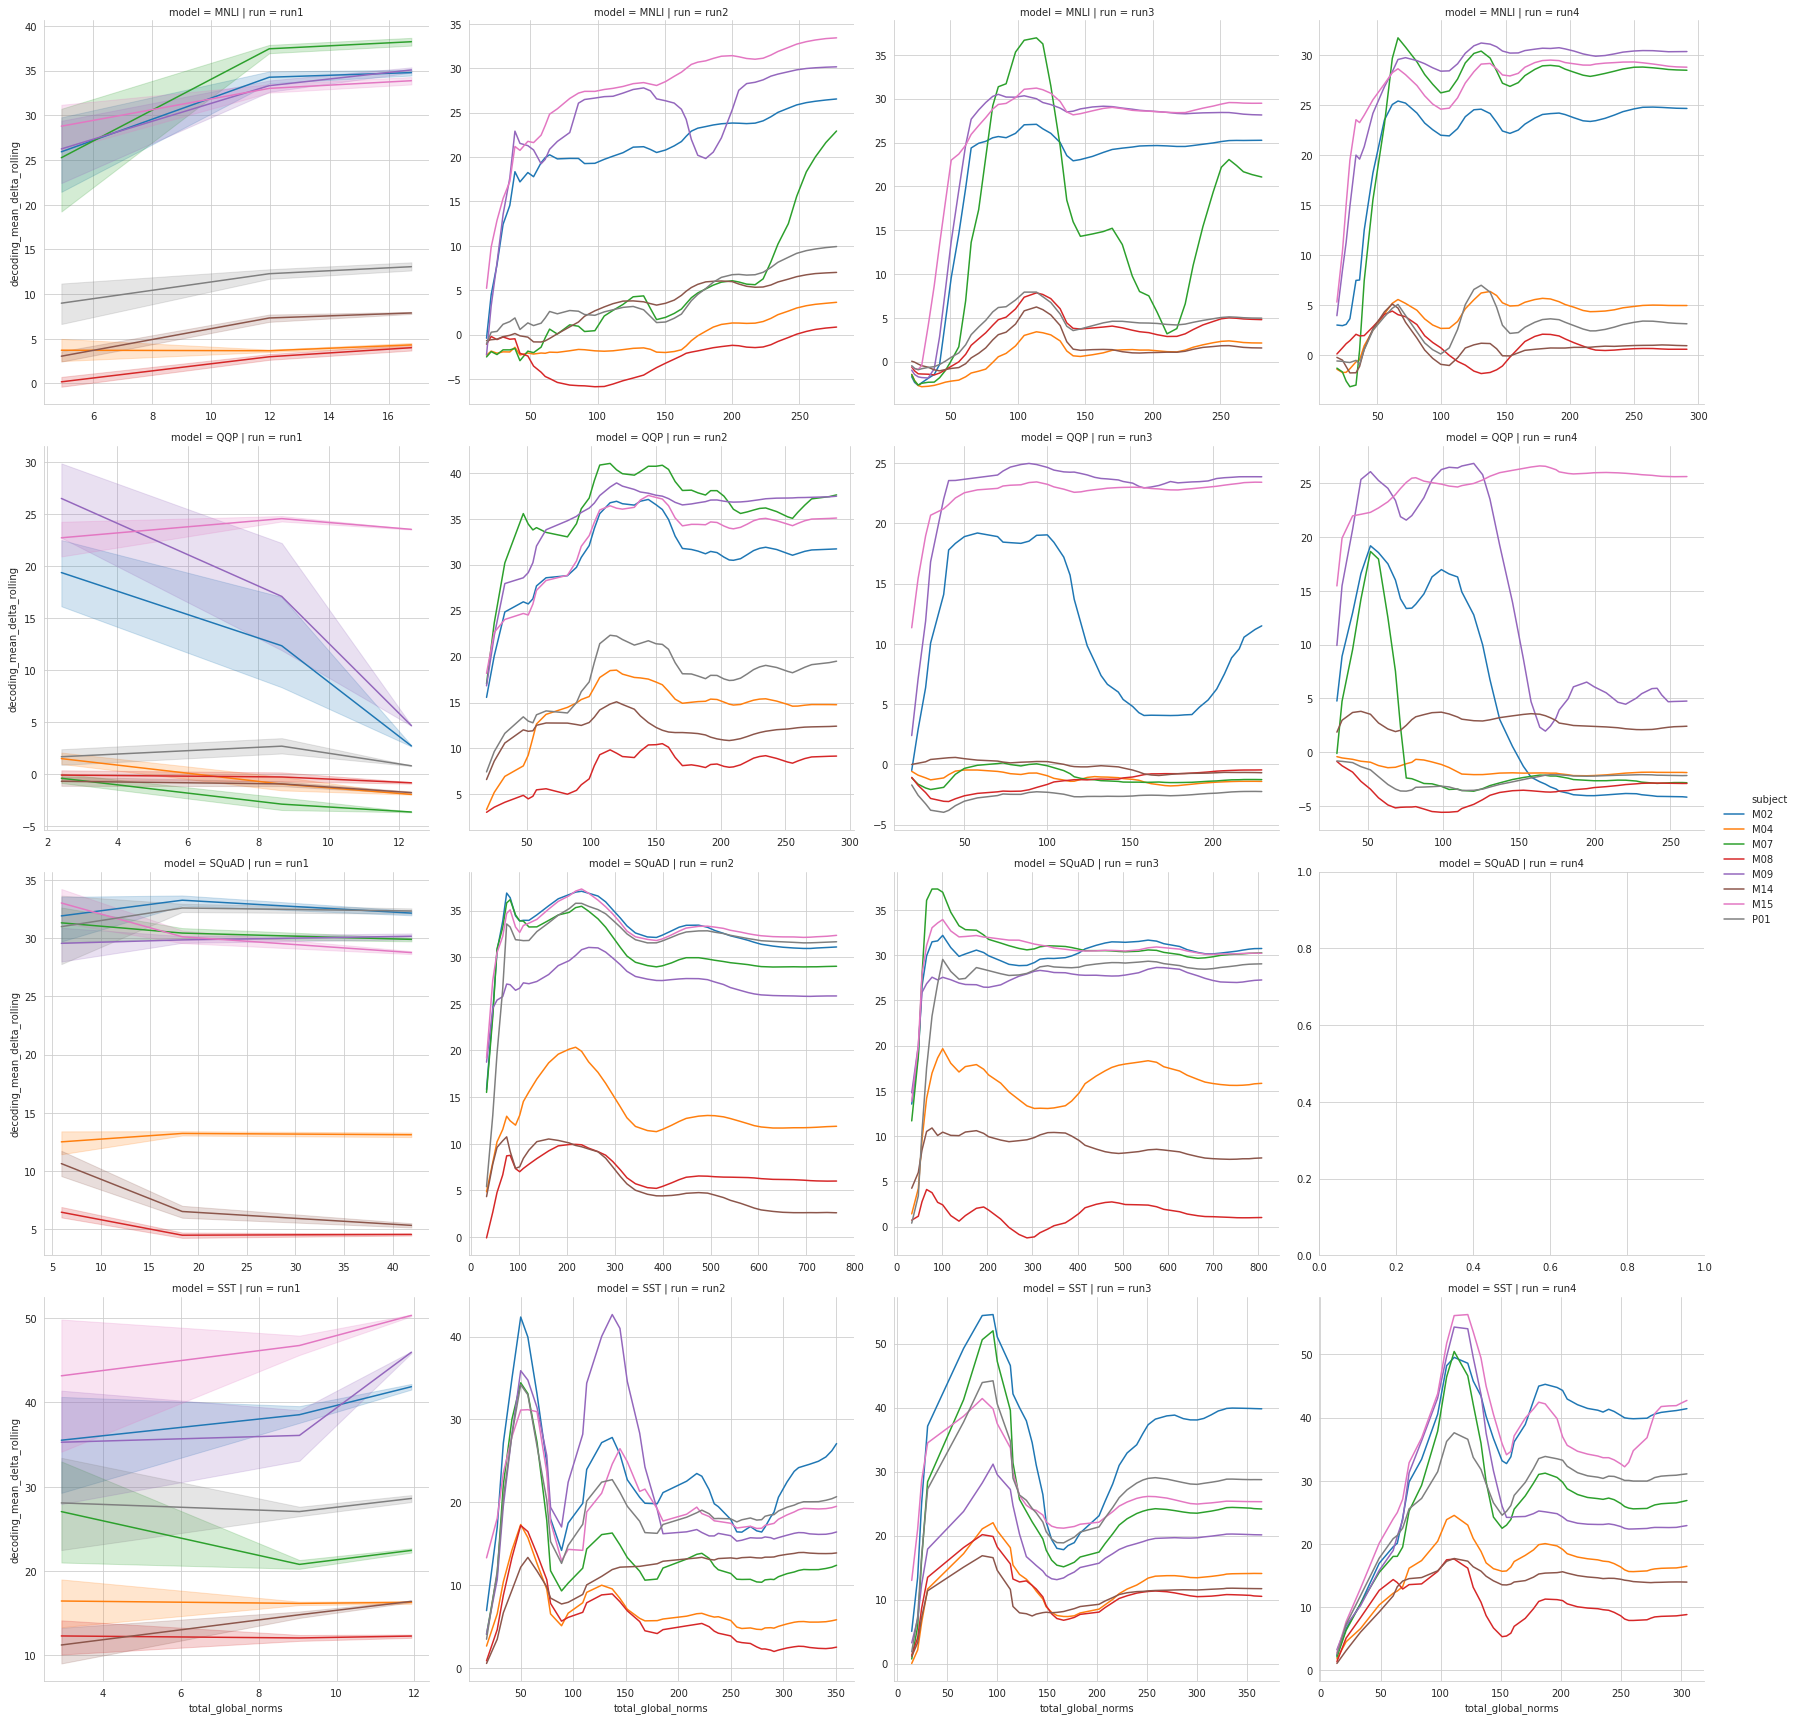

In [29]:
g = sns.FacetGrid(df[(df.model != "LM") & (df.run != "NA")], row="model", col="run", size=6, sharex=False, sharey=False)
g.map(sns.lineplot, "total_global_norms", "decoding_mean_delta_rolling", "subject").add_legend()

### Eval accuracy analysis

(-10, 60)

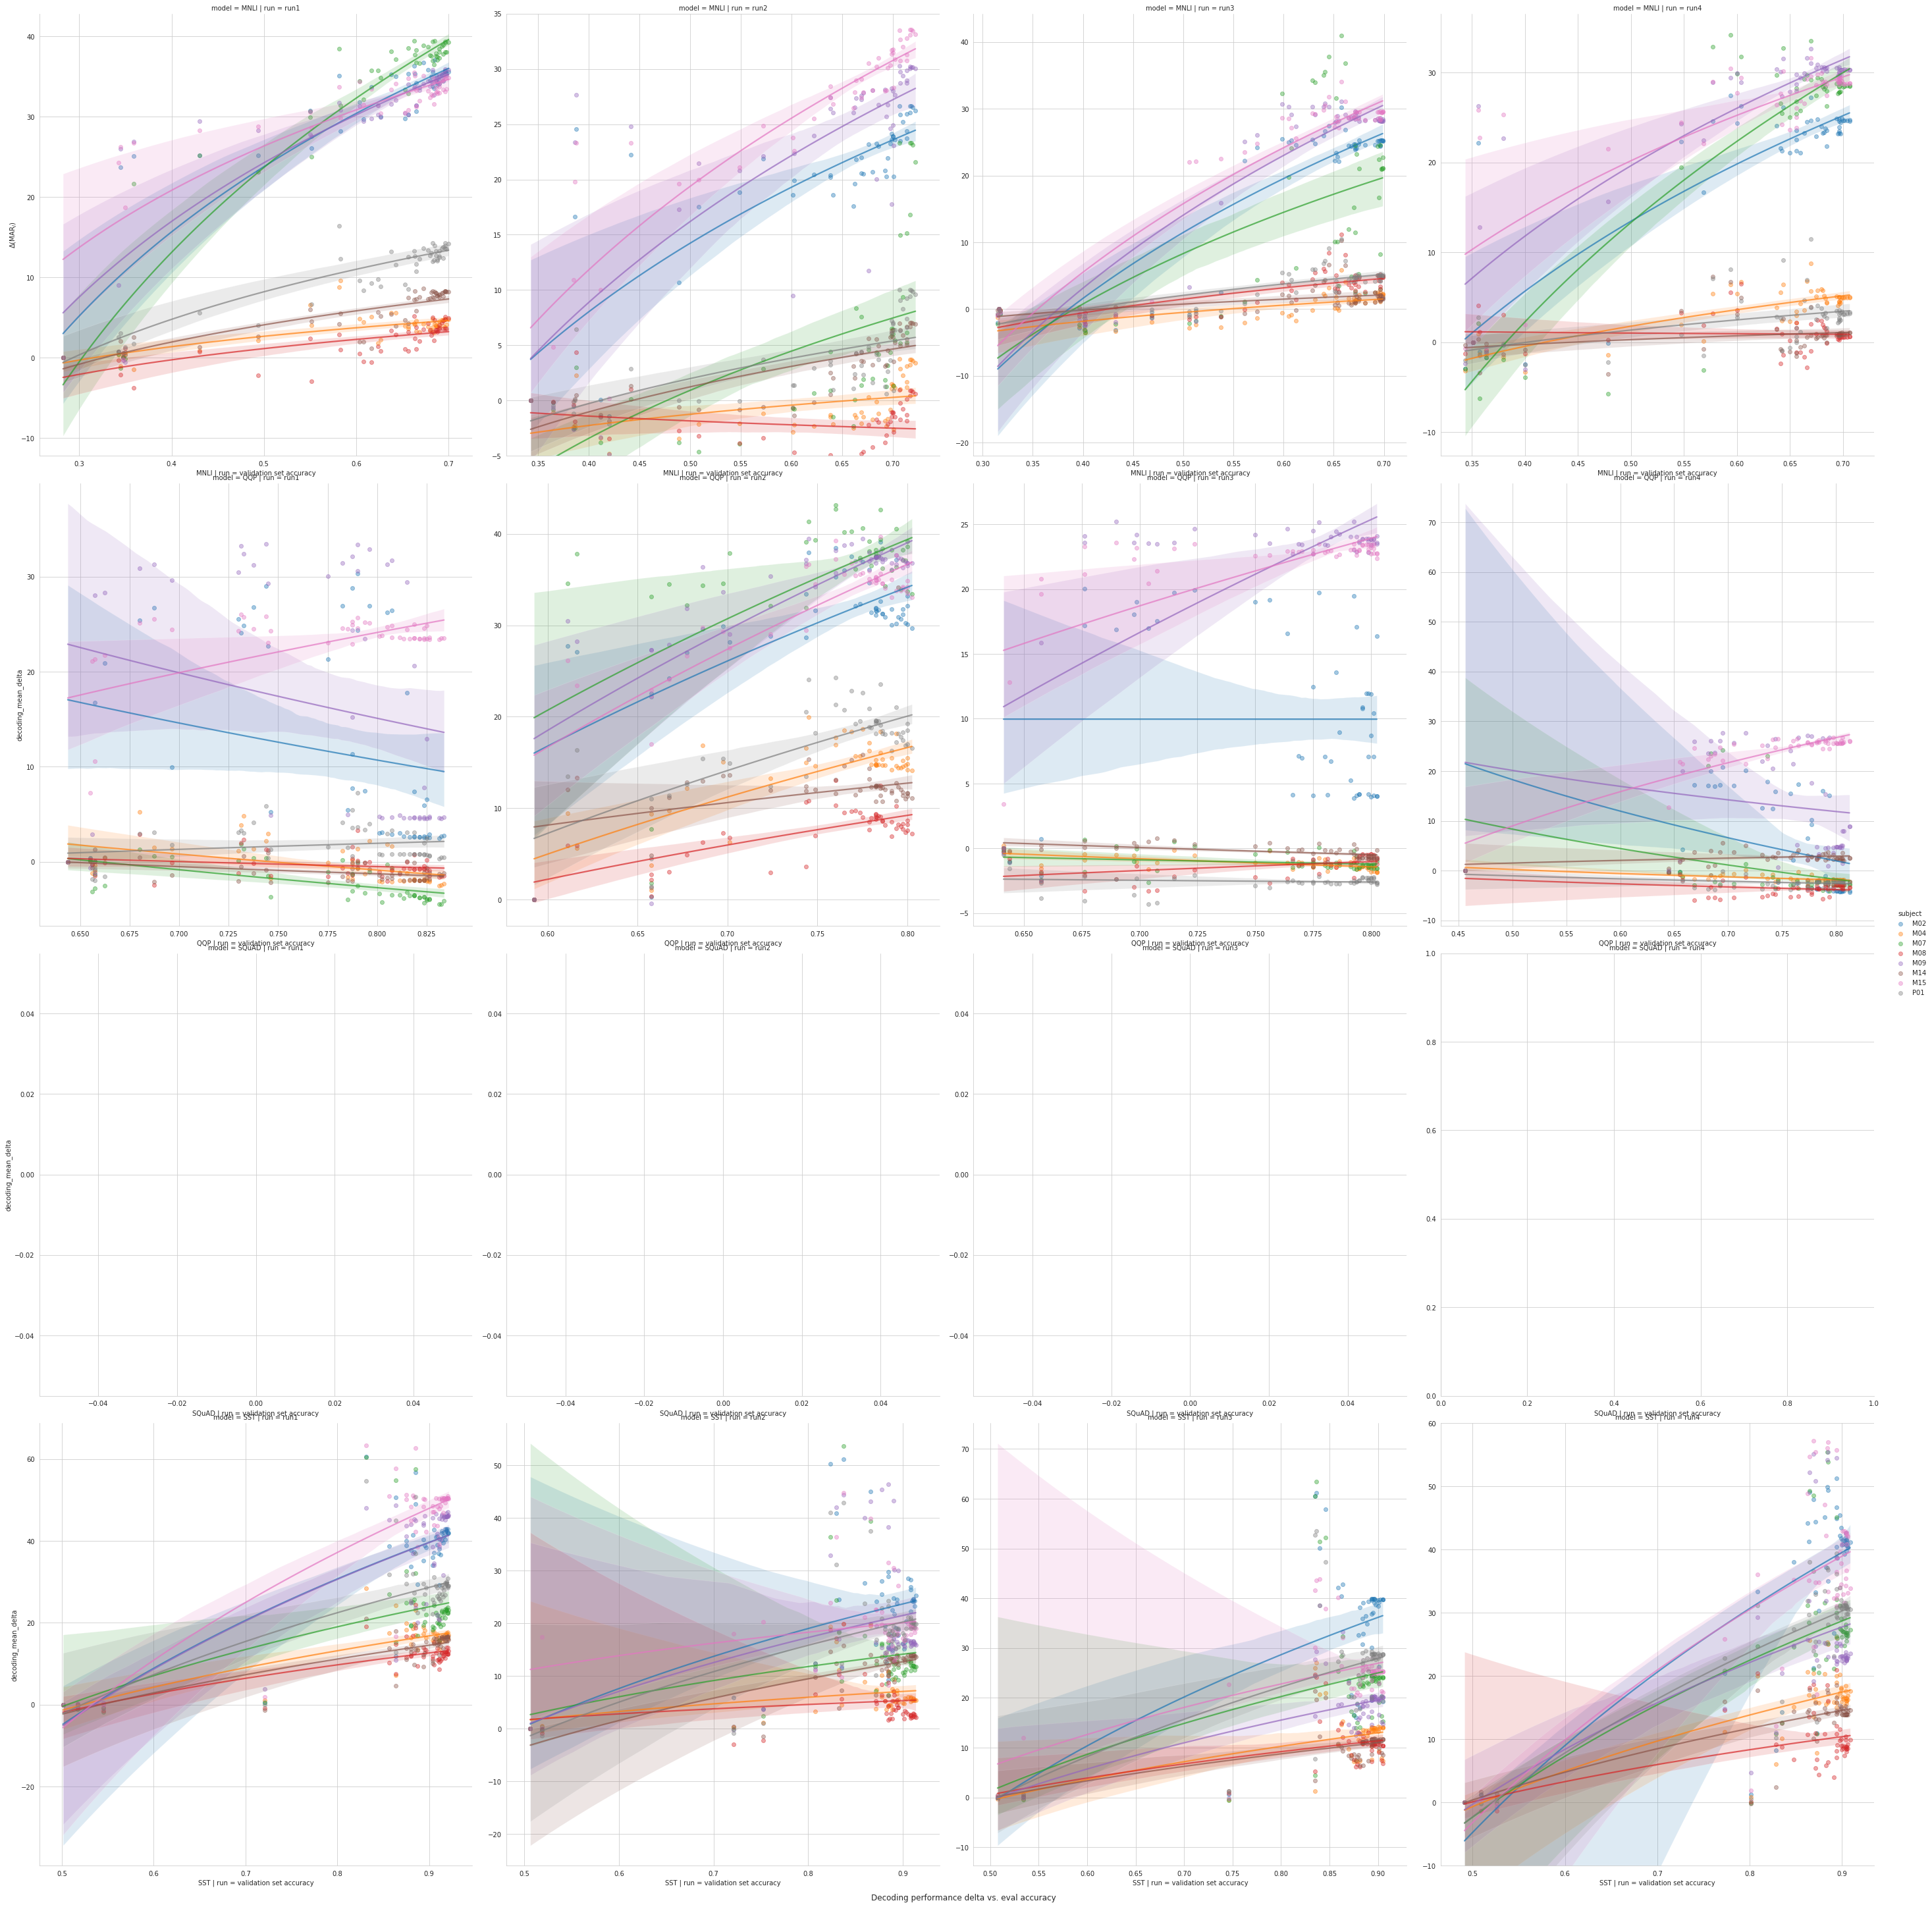

In [30]:
g = sns.lmplot(data=df[(df.model != "LM") & (df.run != "NA")], y="decoding_mean_delta", x="eval_accuracy", col="run", hue="subject", row="model",
               sharex=False, sharey=False, truncate=True, logx=True, scatter_kws={"alpha": 0.4}, line_kws={"alpha": 0.7}, height=10)
plt.suptitle("Decoding performance delta vs. eval accuracy", y=0.0)

axs = g.axes.ravel()
axs[0].set_ylabel(MAR_DELTA_LABEL)
for ax in axs:
    model_name = re.search(r"model = (.+) ", ax.get_title())
    ax.set_xlabel("%s validation set accuracy" % model_name.group(1))
axs[1].set_ylim((-5, 35)) # QQP
axs[-1].set_ylim((-10, 60)) # SNLI

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


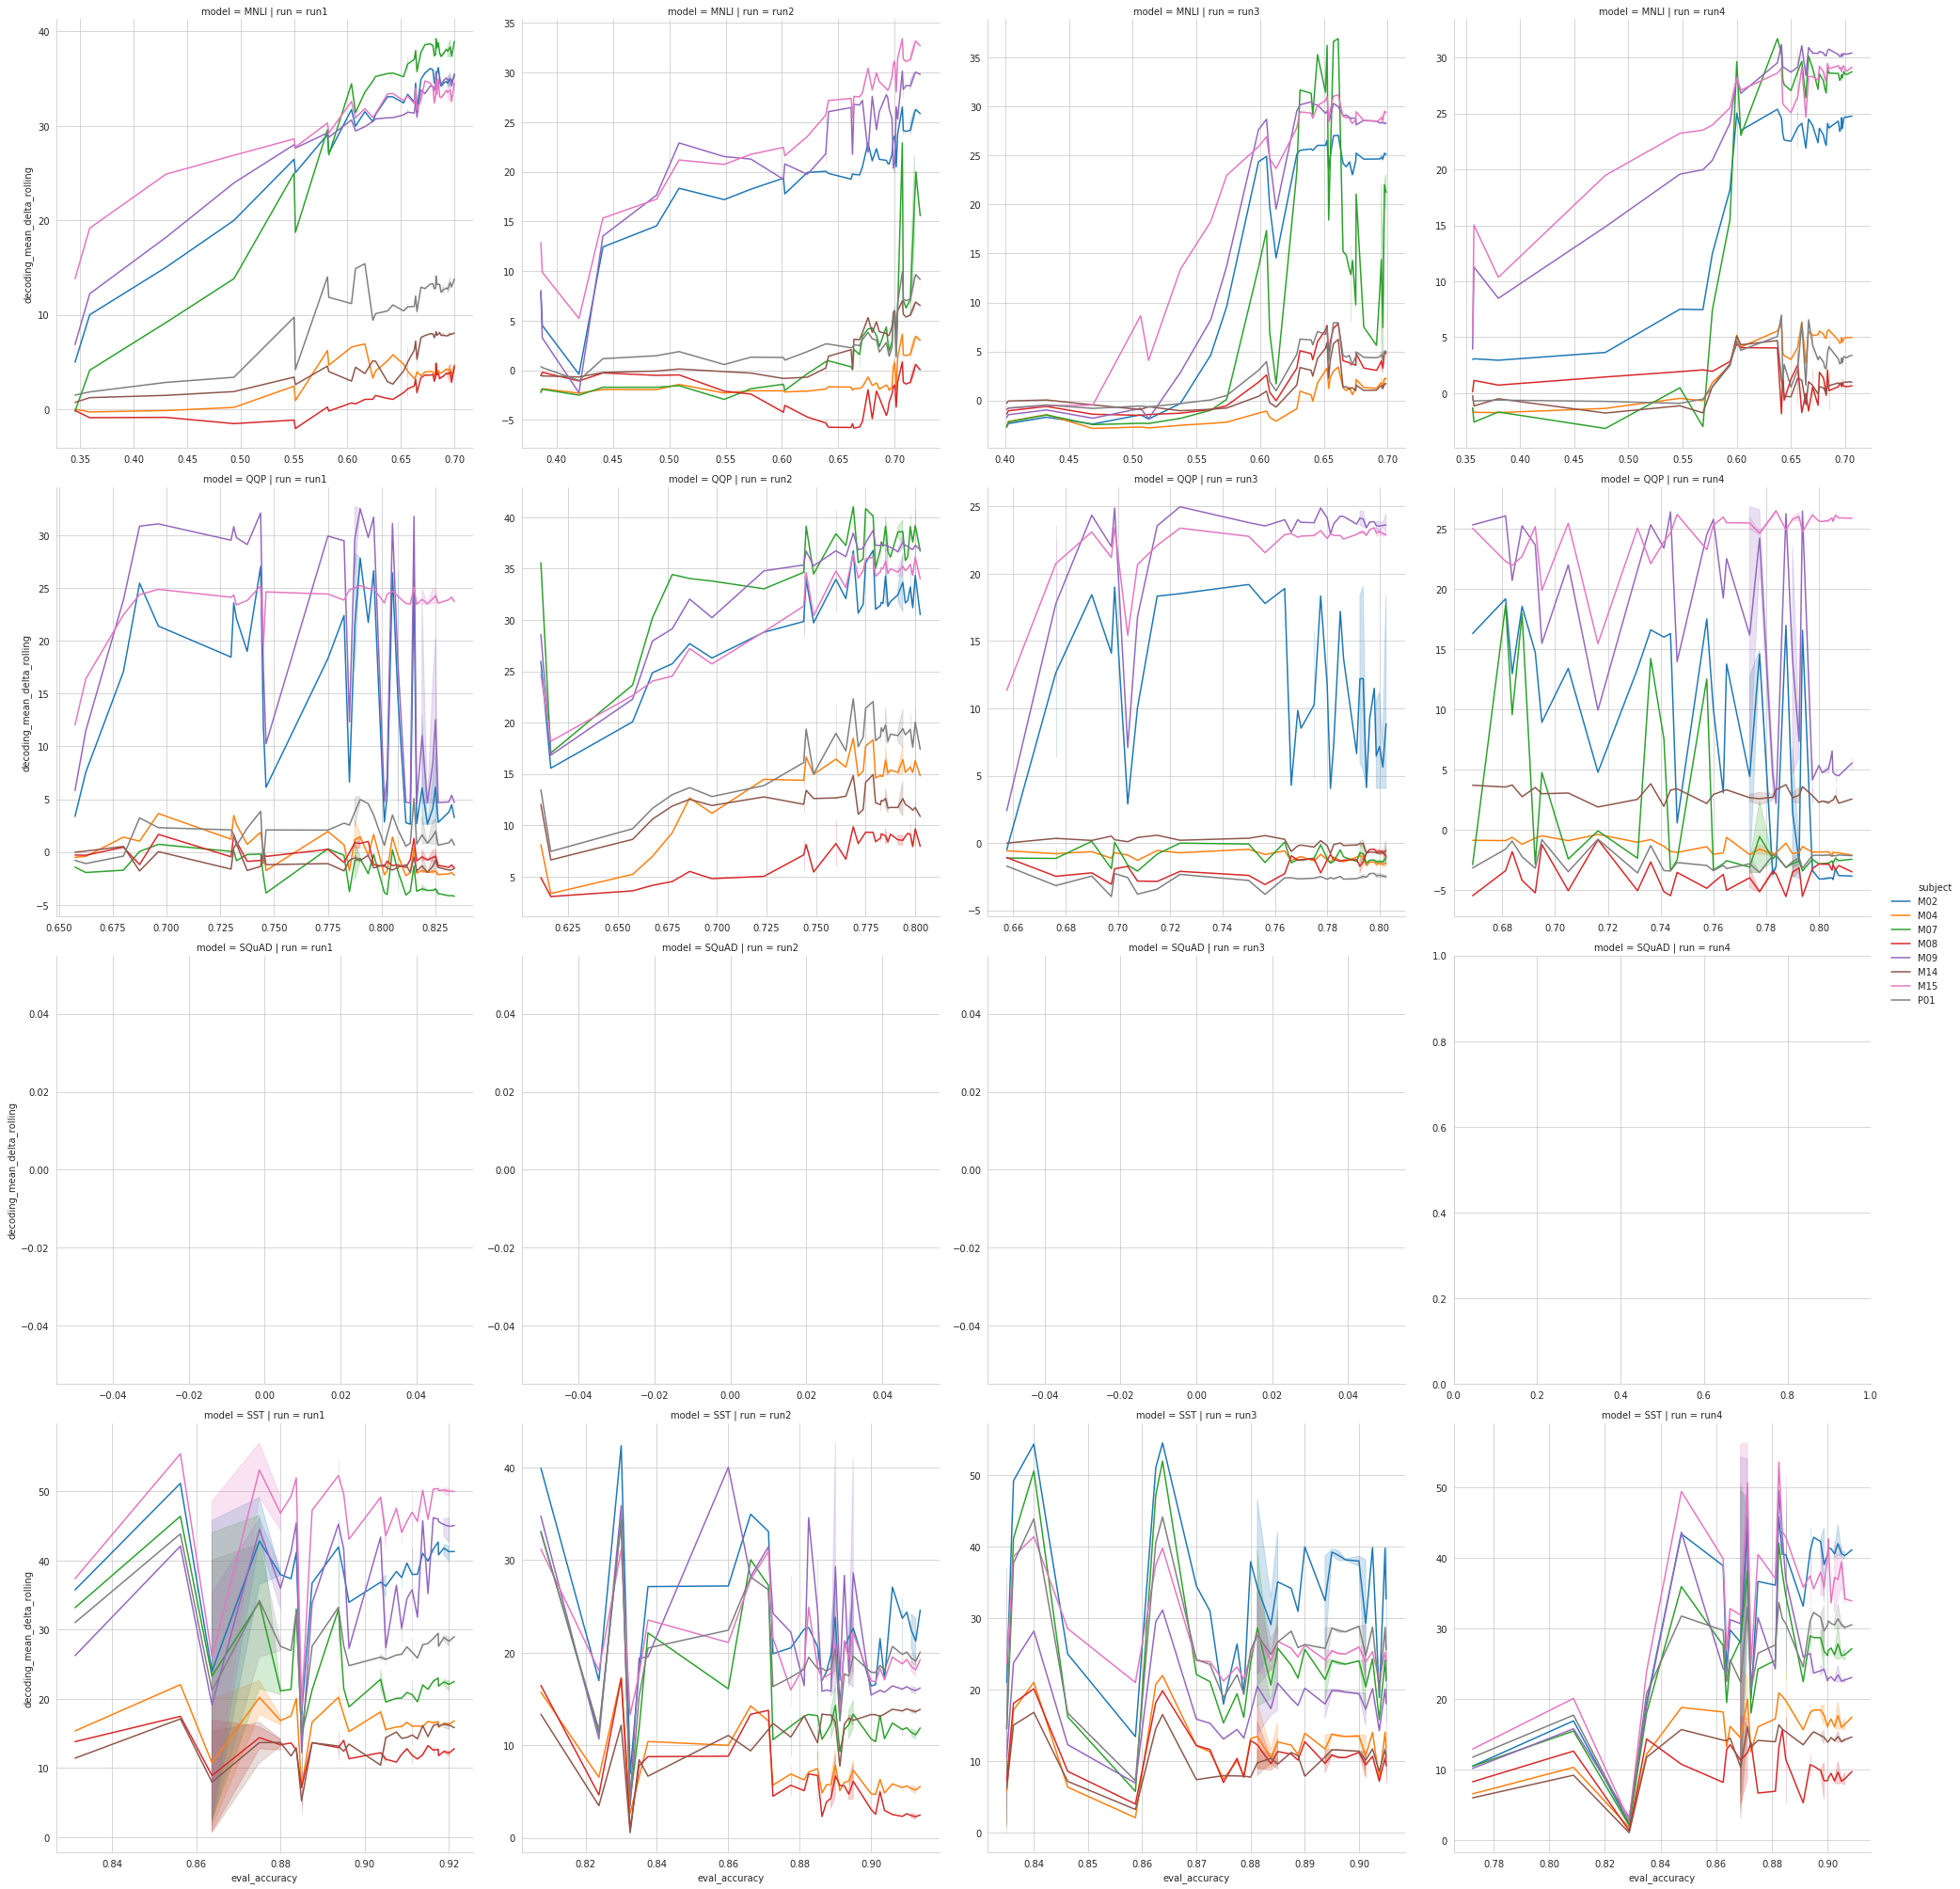

In [32]:
g = sns.FacetGrid(df[(df.model != "LM") & (df.run != "NA")], row="model", col="run", sharex=False, sharey=False, size=7)
g.map(sns.lineplot, "eval_accuracy", "decoding_mean_delta_rolling", "subject").add_legend()

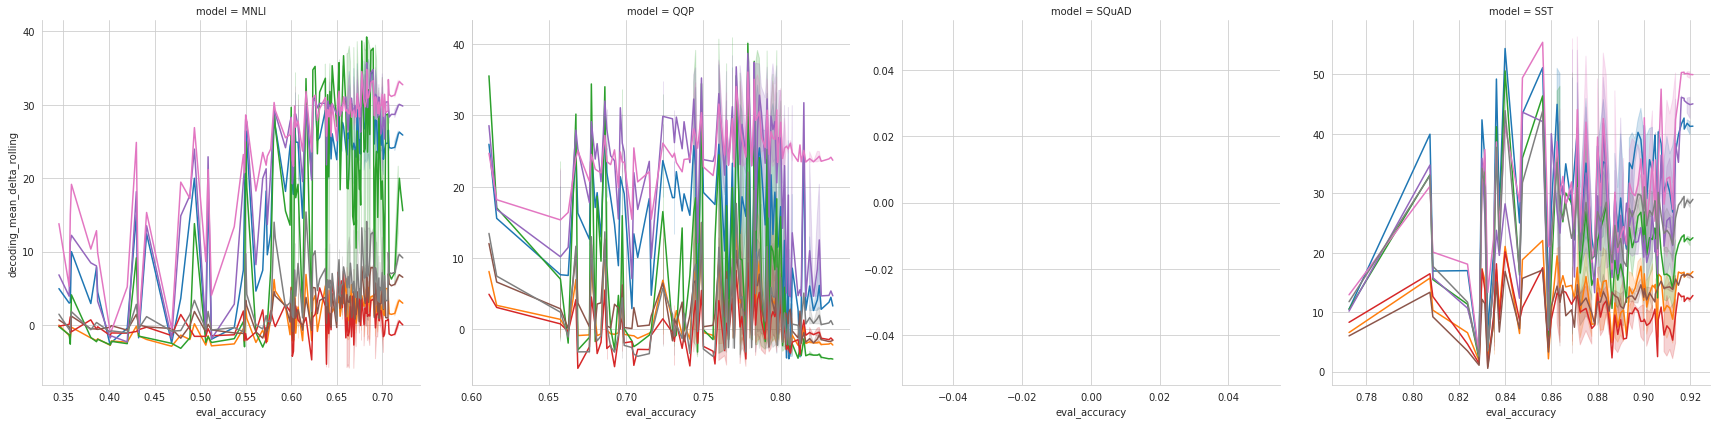

In [36]:
g = sns.FacetGrid(df[(df.model != "LM") & (df.run != "NA")], col="model", height=6, sharex=False, sharey=False)
g.map(sns.lineplot, "eval_accuracy", "decoding_mean_delta_rolling", "subject")

## Per-subject analysis

Text(0.5,1,'subject average decoding mean delta, averaging across runs')

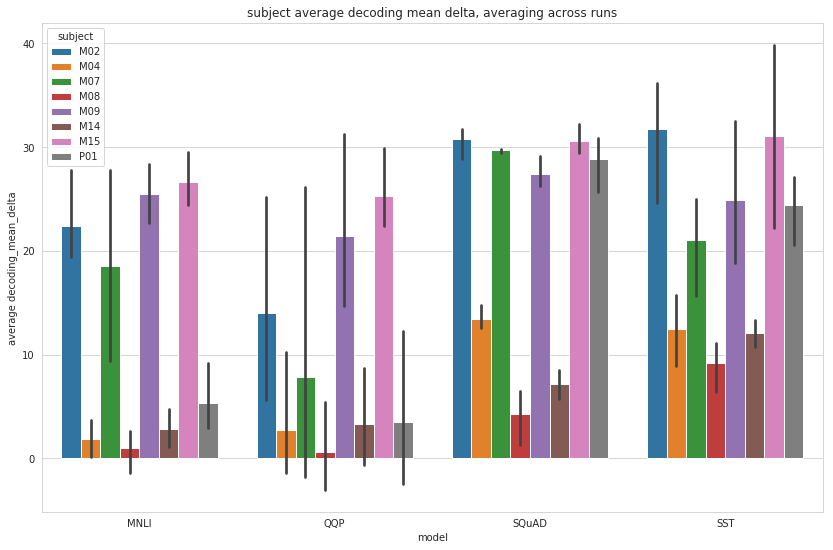

In [38]:
f, ax = plt.subplots(figsize=(14, 9))
dff = df[(df.model != "LM") & (df.run != "NA")].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mean_delta.mean()).reset_index().melt(id_vars=["model", "run"], value_name="average decoding_mean_delta")
sns.barplot(data=dff, x="model", hue="subject", y="average decoding_mean_delta", ax=ax)
plt.title("subject average decoding mean delta, averaging across runs")

Text(0.5,1,'subject max decoding mean delta, averaging across runs')

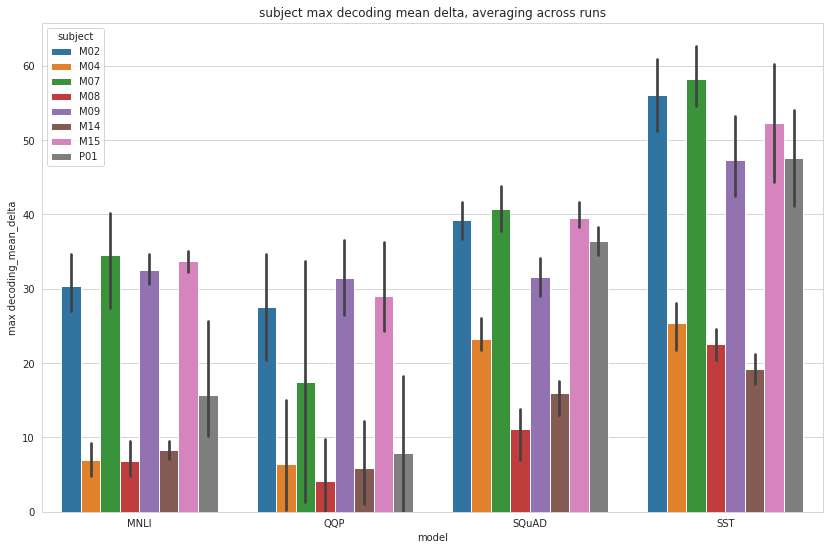

In [39]:
f, ax = plt.subplots(figsize=(14, 9))
dff = df[(df.model != "LM") & (df.run != "NA")].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mean_delta.max()).reset_index().melt(id_vars=["model", "run"], value_name="max decoding_mean_delta")
sns.barplot(data=dff, x="model", hue="subject", y="max decoding_mean_delta", ax=ax)
plt.title("subject max decoding mean delta, averaging across runs")

Text(0.5,1,'subject average decoding mean delta, averaging across models and runs')

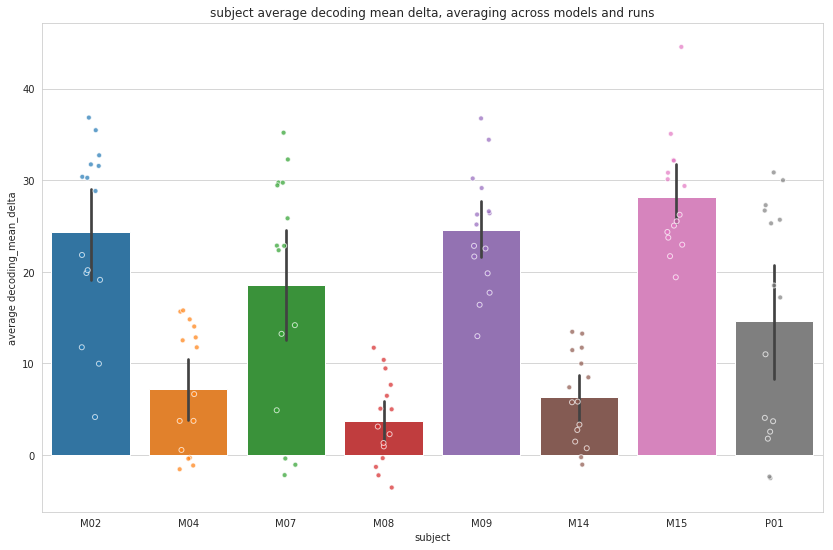

In [63]:
f, ax = plt.subplots(figsize=(14, 9))
dff = df[(df.model != "LM") & (df.run != "NA")].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mean_delta.mean()).reset_index().melt(id_vars=["model", "run"], value_name="average decoding_mean_delta")
sns.barplot(data=dff, x="subject", y="average decoding_mean_delta", ax=ax)
sns.stripplot(data=dff, x="subject", y="average decoding_mean_delta", edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject average decoding mean delta, averaging across models and runs")

Text(0.5,1,'subject max decoding mean delta, averaging across models and runs')

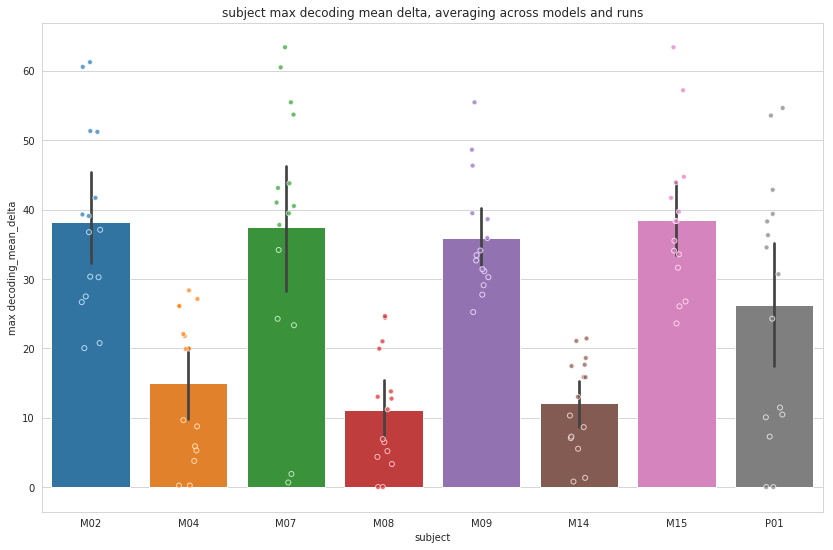

In [40]:
f, ax = plt.subplots(figsize=(14, 9))
dff = df[(df.model != "LM") & (df.run != "NA")].groupby(["model", "run"]).apply(lambda xs: xs.groupby("subject").decoding_mean_delta.max()).reset_index().melt(id_vars=["model", "run"], value_name="max decoding_mean_delta")
sns.barplot(data=dff, x="subject", y="max decoding_mean_delta", ax=ax)
sns.stripplot(data=dff, x="subject", y="max decoding_mean_delta", edgecolor="white", linewidth=1, alpha=0.7, ax=ax)
plt.title("subject max decoding mean delta, averaging across models and runs")

In [41]:
wilcoxon_input = {
    "%s-%s" % (model, run if model is not None else ""): "bert.base%s" 
        % ("" if model is None
           else ".%s-%s-250%s" % (finetune_desc, model, "" if run is None else "-%s" % run))
    for model in bert_models
    for run in target_runs
}
wilcoxon_input = {
    k: v for k, v in wilcoxon_input.items()
    if Path("perf.384sentences.%s.pred.csv" % v).exists()
}

model_re = re.compile("^(\w+)-")
pairs = {
    (run1, run2)
    for run1, run2 in itertools.combinations(wilcoxon_input.keys(), 2)
    if model_re.match(run1).group(1) != model_re.match(run2).group(1)
}

wilcoxon_results = util.wilcoxon_rank_preds(wilcoxon_input, pairs=pairs)
wilcoxon_results["significant_bonferroni"] = wilcoxon_results.p_val_corrected < 0.01
wilcoxon_results.head()

1.2626262626262626e-05 792


w_stat     p_val  p_val_corrected  \
model1    model2   subject                                       
MNLI-run1 SST-run1 M02      32841.5  0.188382       149.198932   
                   M04      30889.5  0.046080        36.495211   
                   M07      27433.0  0.000147         0.116526   
                   M08      31801.0  0.119003        94.250463   
                   M09      30475.0  0.034699        27.481926   

                            significant_bonferroni  
model1    model2   subject                          
MNLI-run1 SST-run1 M02                       False  
                   M04                       False  
                   M07                       False  
                   M08                       False  
                   M09                       False

In [43]:
wilcoxon_results.groupby("subject").significant_bonferroni.agg(["sum", "mean"])

sum      mean
subject                
M02      46.0  0.464646
M04       3.0  0.030303
M07      45.0  0.454545
M08       0.0  0.000000
M09      29.0  0.292929
M14       0.0  0.000000
M15      19.0  0.191919
P01      53.0  0.535354

Text(0.5,1,'# significant comparisons between decoding predictions on fine-tune model pairs')

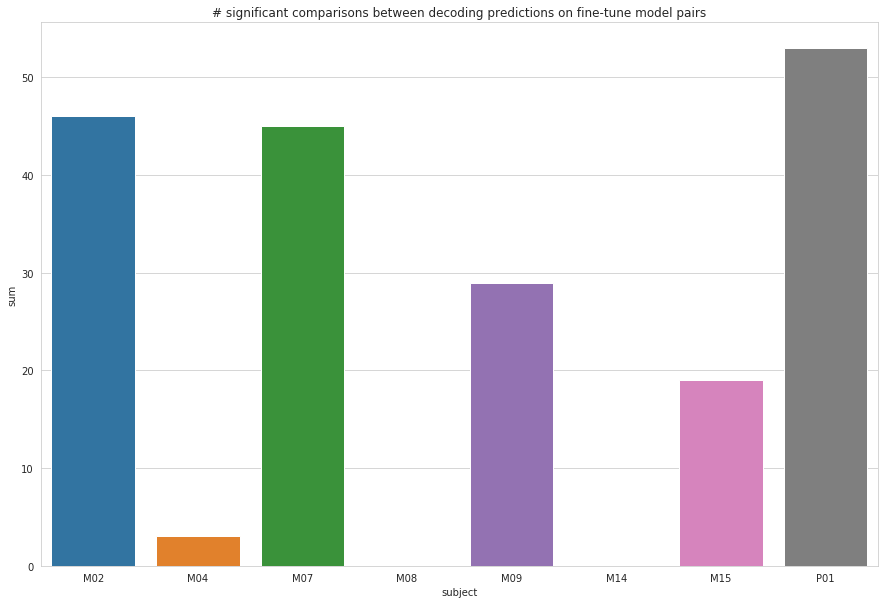

In [52]:
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(data=wilcoxon_results.groupby("subject").significant_bonferroni.agg(["sum"]).reset_index(),
            x="subject", y="sum", ax=ax)
plt.title("# significant comparisons between decoding predictions on fine-tune model pairs")

## Regression analyses

In [32]:
from statsmodels.tools import tools

ols_results = []
for (model, subject), model_data in df[df.model != "LM"].groupby(["model", "subject"]):
    X = model_data.eval_accuracy * 100
    # Add bias term.
    #X = np.concatenate([X[:, np.newaxis], np.ones((X.shape[0], 1))], axis=1)
    X = tools.add_constant(X)
    #X -= X.mean()
    #X /= X.std()
    y = model_data.decoding_mean_delta
    #y -= y.mean()
    #y /= y.std()
    
    reg = smf.OLS(y, X).fit()
    ols_results.append((model, subject, reg.params.eval_accuracy, reg.params.const, reg.rsquared))
    
#     print(model, subject)
#     print(reg.summary())

ols_results = pd.DataFrame(ols_results, columns=["model", "subject", "slope", "intercept", "r2"])

MissingDataError: exog contains inf or nans

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
bins = np.linspace(ols_results.slope.min(), ols_results.slope.max(), 10)
for model, ols_results_m in ols_results.groupby("model"):
    sns.distplot(ols_results_m.slope, bins=bins, ax=ax, kde=False)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
bins = np.linspace(ols_results.intercept.min(), ols_results.intercept.max(), 10)
for model, ols_results_m in ols_results.groupby("model"):
    sns.distplot(ols_results_m.intercept, bins=bins, ax=ax, kde=False)

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))

sns.swarmplot(data=ols_results, x="model", y="slope", ax=ax)
sns.boxplot(data=ols_results, x="model", y="slope", ax=ax, boxprops=dict(alpha=0.3))
ax.set_ylabel("Estimated %s / $\Delta$(Eval accuracy)" % MAR_DELTA_LABEL)

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))

sns.swarmplot(data=ols_results, x="model", y="intercept", ax=ax)
sns.boxplot(data=ols_results, x="model", y="intercept", ax=ax, boxprops=dict(alpha=0.3))
ax.set_ylabel("Estimated intercept")

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="subject", hue="model", y="slope", ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="model", hue="subject", y="slope", ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="subject", hue="model", y="intercept", ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(15, 8))
sns.barplot(data=ols_results, x="model", hue="subject", y="intercept", ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=ols_results, x="model", y="r2", hue="subject", ax=ax)

In [ ]:
ols_results.sort_values("r2")

In [ ]:
%load_ext rpy2.ipython
%R require(brms)

In [ ]:
regression_data = df[df.model.notnull()]
regression_data.to_csv("regression_data.csv")

In [ ]:
%R summary(brm("decoding_mean ~ eval_accuracy + (1 + eval_accuracy | subject) + (1 + eval_accuracy | model)",
               data=read.csv("regression_data.csv"), iter=2000, chains=10, cores=10))

R results from the above regression, run from the command line (19 Feb 2019 12:46):

```
> ranef(mylm)
$model
, , Intercept

      Estimate Est.Error      Q2.5     Q97.5
MNLI  16.75141  22.41457 -28.67321 62.633228
QQP   33.96295  22.71539 -10.84474 80.443706
SST  -51.11941  22.68847 -97.77289 -5.678948

, , eval_accuracy

      Estimate Est.Error        Q2.5      Q97.5
MNLI -17.34233  32.23074  -82.818005  46.545622
QQP  -60.07987  32.50367 -126.434392   4.141062
SST   73.80767  32.45963    8.068293 139.260863


$subject
, , Intercept

     Estimate Est.Error        Q2.5      Q97.5
M02 -52.60407  19.08174  -89.177671 -14.155082
M04  60.89416  19.02727   23.720952  99.224670
M07 -28.94065  19.08834  -66.611534   8.715856
M08  35.14006  19.06391   -1.525497  73.038507
M09  57.39263  19.05641   20.876435  95.498854
M14  46.39296  19.10505    9.697139  84.118757
M15 -31.00785  19.16315  -68.451523   7.205317
P01 -92.88771  19.02479 -129.951903 -54.686867

, , eval_accuracy

     Estimate Est.Error        Q2.5     Q97.5
M02  27.99022  13.44256   0.9550976  53.68828
M04 -45.23083  13.34530 -72.4967273 -19.22681
M07  16.20350  13.40520 -10.1863048  43.10497
M08 -29.82243  13.34506 -56.5382954  -3.72094
M09 -41.79735  13.42123 -68.6505984 -15.72548
M14 -10.06899  13.44356 -37.0225402  15.87794
M15  36.78132  13.59707   9.4990463  63.47709
P01  48.49375  13.40848  21.8274816  74.81344

> print(summary(mylm))
 Family: gaussian
  Links: mu = identity; sigma = identity
Formula: decoding_mean ~ eval_accuracy + (1 + eval_accuracy | subject) + (1 + eval_accuracy | model)
   Data: read.csv("regression_data.csv") (Number of observations: 4480)
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects:
~model (Number of levels: 3)
                             Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                   40.63     15.39    20.68    79.10       2248
sd(eval_accuracy)               56.98     18.27    31.11   101.90       2454
cor(Intercept,eval_accuracy)    -0.70      0.29    -0.99     0.07       1846
                             Rhat
sd(Intercept)                1.00
sd(eval_accuracy)            1.00
cor(Intercept,eval_accuracy) 1.00

~subject (Number of levels: 8)
                             Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                   54.54     12.39    35.53    83.32       1440
sd(eval_accuracy)               35.29      8.42    22.94    55.87       1577
cor(Intercept,eval_accuracy)    -0.85      0.12    -0.97    -0.54       2211
                             Rhat
sd(Intercept)                1.00
sd(eval_accuracy)            1.00
cor(Intercept,eval_accuracy) 1.00

Population-Level Effects:
              Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept        68.89     29.31    10.32   125.17       1560 1.00
eval_accuracy    56.19     35.37   -11.61   128.69       1389 1.00

Family Specific Parameters:
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     8.14      0.09     7.97     8.31       4974 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample
is a crude measure of effective sample size, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).
Warning message:
There were 322 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
```

In [ ]:
%R mylm <- brm("decoding_mean ~ log(eval_accuracy) + (1 + log(eval_accuracy) | subject) + (1 + log(eval_accuracy) | model)", data=read.csv("regression_data.csv"), iter=2000, control=list(max_treedepth=15))

R results from the above regression, run on the command line (18 Feb 2019 17:21):

```
> ranef(mylm)
$model
, , Intercept

        Estimate Est.Error       Q2.5     Q97.5
MNLI  -0.8675875  15.13298 -32.433042 30.235024
QQP  -23.6366560  15.13622 -55.387579  7.397331
SST   22.1441808  15.14019  -9.242302 52.952531

, , logeval_accuracy

      Estimate Est.Error        Q2.5     Q97.5
MNLI -15.19145  31.06674  -78.348188  49.57885
QQP  -41.12545  31.15355 -104.168428  22.72867
SST   53.46094  31.11354   -9.910603 119.74002


$subject
, , Intercept

      Estimate Est.Error       Q2.5      Q97.5
M02 -26.421842  10.45573 -47.257870  -6.309088
M04  17.524082  10.42141  -3.029840  37.743235
M07 -14.033033  10.43504 -34.808899   6.218818
M08   6.260752  10.44637 -14.783196  26.722411
M09  17.670682  10.42522  -3.079233  38.154109
M14  36.111953  10.43270  15.420709  56.384843
M15   3.572897  10.44743 -17.174979  23.966986
P01 -47.612600  10.44023 -68.451741 -27.314897

, , logeval_accuracy

      Estimate Est.Error        Q2.5      Q97.5
M02  17.512027  9.169878  -0.3198393 36.1756958
M04 -26.612520  9.254896 -45.4697303 -8.2981598
M07   9.935814  9.191353  -8.2876422 28.3847439
M08 -18.202115  9.114860 -36.2836541 -0.4659212
M09 -22.337849  9.196614 -40.7158639 -4.4865540
M14  -7.280584  9.148384 -25.3590395 10.4895344
M15  23.141154  9.242823   5.1133918 42.1331905
P01  27.737438  9.122779  10.2663030 46.6575899

> print(summary(mylm)
+ )
 Family: gaussian
  Links: mu = identity; sigma = identity
Formula: decoding_mean ~ log(eval_accuracy) + (1 + log(eval_accuracy) | subject) + (1 + log(eval_accuracy) | model)
   Data: read.csv("regression_data.csv") (Number of observations: 4480)
Samples: 4 chains, each with iter = 2000; warmup = 1000; thin = 1;
         total post-warmup samples = 4000

Group-Level Effects:
~model (Number of levels: 3)
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                      27.24     13.11    11.79    61.57       2603
sd(logeval_accuracy)               51.11     21.96    24.58   107.47       2636
cor(Intercept,logeval_accuracy)     0.55      0.37    -0.34     0.97       3216
                                Rhat
sd(Intercept)                   1.00
sd(logeval_accuracy)            1.00
cor(Intercept,logeval_accuracy) 1.00

~subject (Number of levels: 8)
                                Estimate Est.Error l-95% CI u-95% CI Eff.Sample
sd(Intercept)                      30.08      8.40    18.34    51.22       1603
sd(logeval_accuracy)               24.68      7.35    14.47    42.45       1888
cor(Intercept,logeval_accuracy)    -0.56      0.25    -0.89     0.07       2196
                                Rhat
sd(Intercept)                   1.00
sd(logeval_accuracy)            1.00
cor(Intercept,logeval_accuracy) 1.00

Population-Level Effects:
                 Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
Intercept          123.17     17.75    87.90   159.74       1914 1.00
logeval_accuracy    37.93     32.30   -29.31   101.19       2436 1.00

Family Specific Parameters:
      Estimate Est.Error l-95% CI u-95% CI Eff.Sample Rhat
sigma     8.31      0.09     8.14     8.49       6210 1.00

Samples were drawn using sampling(NUTS). For each parameter, Eff.Sample
is a crude measure of effective sample size, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).
Warning message:
There were 13 divergent transitions after warmup. Increasing adapt_delta above 0.8 may help.
See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
```

In [ ]:
%R -o ran ran=ranef(mylm)

In [ ]:
%R print(summary(mylm))

## Transfer checks

In [ ]:
transfer_results = {}
for model in bert_models:
    # Get original fine-tune accuracy
    # TODO update "finetune" to `finetune_desc` once we have transfer data for the new limited finetune models
    results_path = bert_path / ("%s.%s.%s" % (finetune_desc, bert_base_model, model)) / "eval_results.txt"
    if results_path.exists():
        with results_path.open("r") as results_f:
            acc, = re.findall(r"^eval_accuracy\s*=\s*([\d.-]+)$", results_f.read(), re.M)
            acc = float(acc)
            transfer_results[model, model] = acc
            
for m1, m2 in itertools.product(bert_models, repeat=2):
    results_path = bert_path / ("eval_transfer-%s" % finetune_desc) / ("results-%s-%s.json" % (m1, m2))
    if not results_path.exists():
        continue
        
    with results_path.open("r") as results_f:
        transfer_results[m1, m2] = json.load(results_f)["results"]["eval_accuracy"]

plt.subplots(figsize=(20, 10))
transfer_results = pd.Series(transfer_results)
transfer_results.index.rename(["m1", "m2"], inplace=True)
transfer_results = transfer_results.sort_index().reset_index()
print(transfer_results)

ax = sns.barplot(data=transfer_results, hue="m2", x="m1", y=0)
i = 0
for bar in sorted(ax.patches, key=lambda bar: bar.get_x()):
    row = transfer_results.iloc[i]
    if not np.isnan(bar.get_height()):
        if row.m1 == row.m2:
            bar.set_hatch("/")
            
        i += 1

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(data=pd.pivot_table(transfer_results, index="m1", columns="m2", values=0), annot=True)